In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings

warnings.filterwarnings("ignore")
import hopsworks


def remove_nans(df: pd.DataFrame) -> pd.DataFrame:
    nan_df = df.isna().sum()[df.isna().sum() > 0]
    nan_perc = (nan_df / df.shape[0] * 100).apply(int)
    cols_to_drop = nan_perc[nan_perc >= 20].index
    df = df.drop(cols_to_drop, axis=1).dropna()
    return df

In [2]:
project = hopsworks.login()

fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/384148
Connected. Call `.close()` to terminate connection gracefully.


In [39]:
df_credit = pd.read_csv(
    "/Users/macbook/src/hopswork-pipeline/data/german_credit_data.csv", index_col=0
)

In [40]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [41]:
df_credit.value_counts("Sex")

Sex
male      690
female    310
Name: count, dtype: int64

In [42]:
df_credit.value_counts("Housing")

Housing
own     713
rent    179
free    108
Name: count, dtype: int64

In [43]:
df_credit.value_counts("Saving accounts")

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [44]:
df_credit.value_counts("Purpose")

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64

In [45]:
def one_hot_encoder(df, nan_as_category=False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(
        df, columns=categorical_columns, dummy_na=nan_as_category, drop_first=True
    )
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [46]:
# Let's look the Credit Amount column


df_credit["Saving accounts"] = df_credit["Saving accounts"].fillna("no_inf")
df_credit["Checking account"] = df_credit["Checking account"].fillna("no_inf")
# Purpose to Dummies Variable
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Purpose, drop_first=True, prefix="Purpose"),
    left_index=True,
    right_index=True,
)
# Sex feature in dummies
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Sex, drop_first=True, prefix="Sex"),
    left_index=True,
    right_index=True,
)
# Housing get dummies
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Housing, drop_first=True, prefix="Housing"),
    left_index=True,
    right_index=True,
)
# Housing get Saving Accounts
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix="Savings"),
    left_index=True,
    right_index=True,
)
# Housing get Risk
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Risk, prefix="Risk"), left_index=True, right_index=True
)
# Housing get Checking Account
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix="Check"),
    left_index=True,
    right_index=True,
)
# Housing get Age categorical
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix="Age_cat"),
    left_index=True,
    right_index=True,
)
# Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit["Risk_good"]


df_credit["Credit amount"] = np.log(df_credit["Credit amount"])

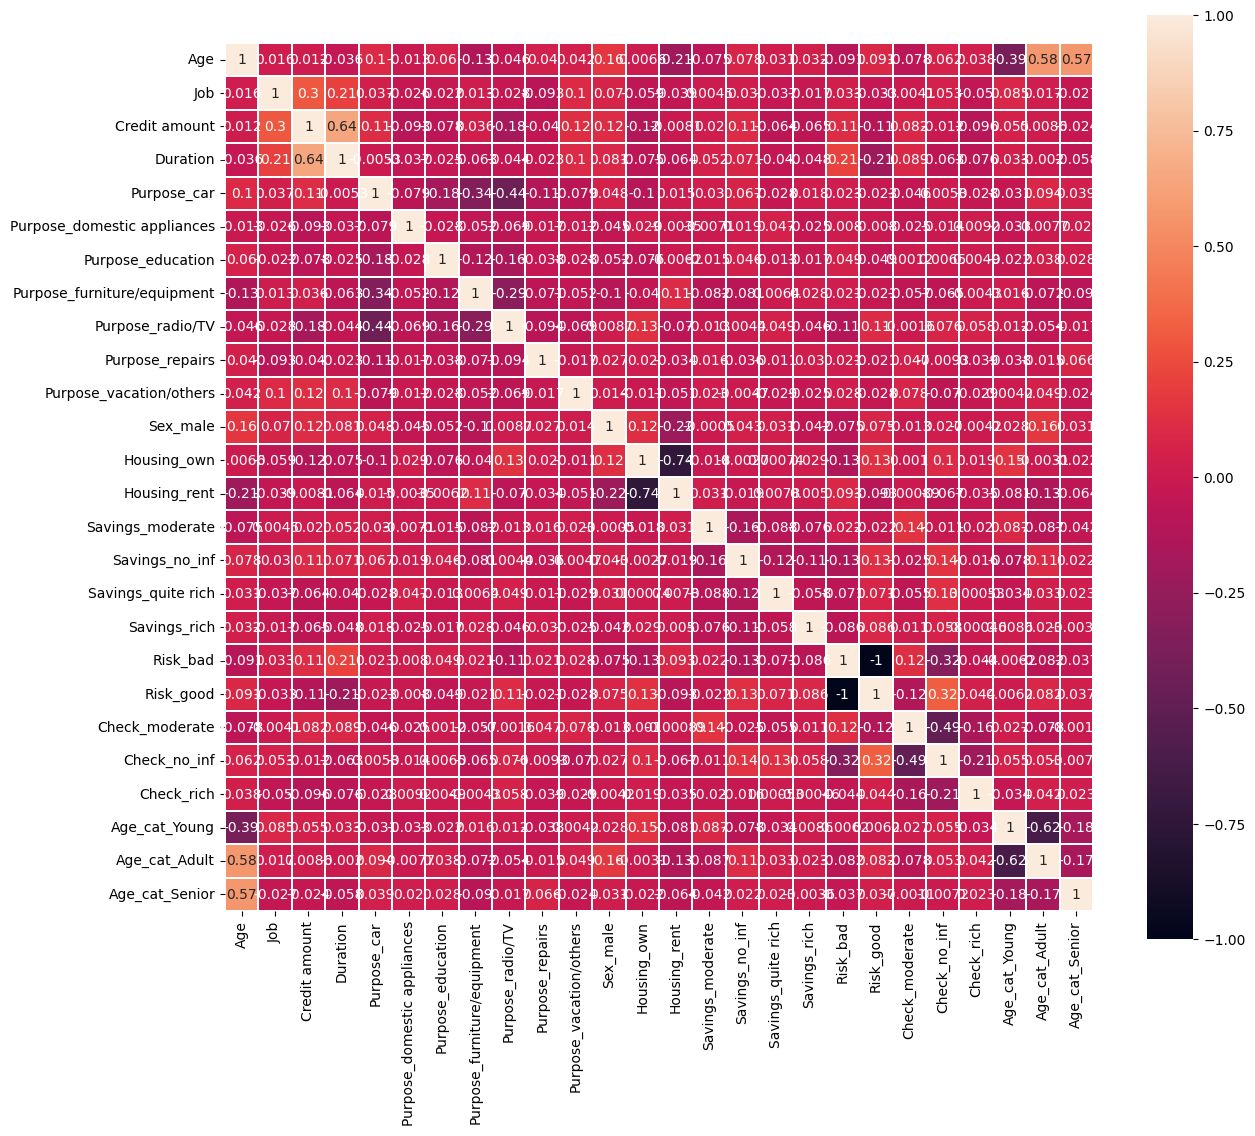

In [47]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    df_credit.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    linecolor="white",
    annot=True,
)
plt.show()

In [54]:
df_credit.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_quite rich,Savings_rich,Risk_bad,Risk_good,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,67,2,7.063904,6,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
1,22,2,8.691315,48,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
2,49,1,7.647786,12,False,False,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
3,45,2,8.972337,42,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,53,2,8.490849,24,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
